In [1]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2024-03-04 15:56:40.092395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import imgaug.augmenters as iaa

In [10]:
images=load_2Dimages(path_train_original1)

In [19]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur with a sigma between 0 and 1.0
    iaa.Affine(rotate=(-45, 45)),  # Rotate between -45 and 45 degrees
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Add Gaussian noise
])

# Apply augmentation to the image
augmented_image = seq(image=images[1])

In [20]:
augmented_image.shape

(512, 512)

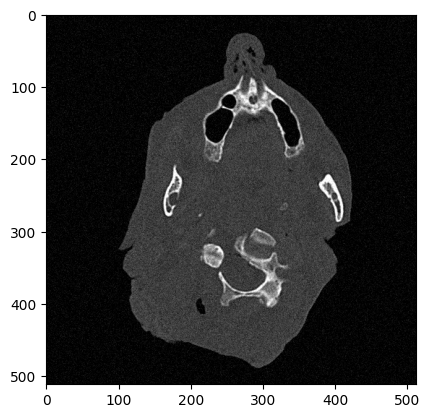

In [21]:
plt.imshow(augmented_image, cmap='gray')

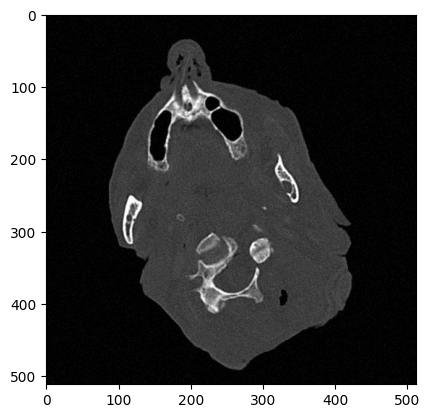

In [15]:
plt.imshow(augmented_image, cmap='gray')

In [9]:
# Load the dataset
def load_2Dimages(folder):
    images = []
    # Keep the information of axis z (each slice)
    file_list = sorted(file for file in os.listdir(folder) if file.endswith('.png'))

    for filename in file_list:
        path = os.path.join(folder, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # grayscale
        if img is not None:
            images.append(img)
    return np.array(images)

In [47]:
def streching(image):
    scale = 0.85
    new_width = int(512 * scale)
    new_height = 512
    resized_image = cv2.resize(image, (new_width, new_height))
    black_background = np.zeros((512, 512), dtype=np.uint8)
    start_x = int((512 - new_width) / 2)
    end_x = start_x + new_width
    black_background[:, start_x:end_x] = resized_image
    
    return black_background

def noiseG(image):
    mean = 0   
    std = 10  
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

def noiseP(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    noisy = np.clip(noisy, 0, 255)
    noisy_image = noisy.astype(np.uint8)
    
    return noisy_image

In [48]:
def patch_original(folder_path):
    images2D = load_2Dimages(folder_path)
    ori = np.stack((images2D,)*3, axis=-1)
    center = (512 // 2, 512 // 2)
    rotated_10 = np.zeros((64,512,512))
    rotated_minus_10 = np.zeros((64,512,512))
    s = np.zeros((64,512,512))
    ng = np.zeros((64,512,512))
    noip = np.zeros((64,512,512))
    for i in range(64):
        # rotation +10
        M = cv2.getRotationMatrix2D(center, 10, 1.0)
        rotated_10[i,:,:] = cv2.warpAffine(images2D[i,:,:], M, (512, 512))
        # rotation -10
        M = cv2.getRotationMatrix2D(center, -10, 1.0)
        rotated_minus_10[i,:,:] = cv2.warpAffine(images2D[i,:,:], M, (512, 512))
        # streching
        s[i,:,:] = streching(images2D[i,:,:])
        # Gaussian
        ng[i,:,:] = noiseG(images2D[i,:,:])
        # Poisson
        noip[i,:,:] = noiseP(images2D[i,:,:])
        
    rotated_10 = np.stack((rotated_10,)*3, axis=-1)
    rotated_minus_10 = np.stack((rotated_minus_10,)*3, axis=-1)
    s = np.stack((s,)*3, axis=-1)
    ng = np.stack((ng,)*3, axis=-1)
    noip = np.stack((noip,)*3, axis=-1)
    
    original = np.concatenate((ori, rotated_10, rotated_minus_10, s, ng, noip), axis=0)
    return original

def ma(images2D):
    mask_2_channels = np.zeros(images2D.shape + (2,))
    indices_greater_than_0_5 = np.where(images2D > 5)
    for idx in zip(*indices_greater_than_0_5):
        mask_2_channels[idx[0],idx[1],idx[2],0] = 1

    indices_smaller_than_0_5 = np.where(images2D < 5)
    for idx in zip(*indices_smaller_than_0_5):
        mask_2_channels[idx[0],idx[1],idx[2],1] = 1

    return mask_2_channels

def patch_mask(folder_path):
    images2D = load_2Dimages(folder_path)
    ori = ma(images2D)
    
    center = (512 // 2, 512 // 2)
    rotated_10 = np.zeros((64,512,512))
    rotated_minus_10 = np.zeros((64,512,512))
    s = np.zeros((64,512,512))
    ng = np.zeros((64,512,512))
    noip = np.zeros((64,512,512))
    for i in range(64):
        # rotation +10
        M = cv2.getRotationMatrix2D(center, 10, 1.0)
        rotated_10[i,:,:] = cv2.warpAffine(images2D[i,:,:], M, (512, 512))
        # rotation -10
        M = cv2.getRotationMatrix2D(center, -10, 1.0)
        rotated_minus_10[i,:,:] = cv2.warpAffine(images2D[i,:,:], M, (512, 512))
        # streching
        s[i,:,:] = streching(images2D[i,:,:])
        # Gaussian
        ng[i,:,:] = noiseG(images2D[i,:,:])
        # Poisson
        noip[i,:,:] = noiseP(images2D[i,:,:])
    
    rotated_10 = ma(rotated_10)
    rotated_minus_10 = ma(rotated_minus_10)
    s = ma(s)
    ng = ma(ng)
    noip = ma(noip)
    
    mask = np.concatenate((ori, rotated_10, rotated_minus_10, s, ng, noip), axis=0)
    return mask

In [20]:
# Training set
#path_train_original = "/Users/yichunsun/Desktop/TFM/Data/2D/Training/Original"
#path_train_mask = "/Users/yichunsun/Desktop/TFM/Data/2D/Training/Mask"

# Validation set
#path_validation_original = "/Users/yichunsun/Desktop/TFM/Data/2D/Validation/Original"
#path_validation_mask = "/Users/yichunsun/Desktop/TFM/Data/2D/Validation/Mask"

# Test set
#path_test_original = "/Users/yichunsun/Desktop/TFM/Data/2D/Test/Original"
#path_test_mask = "/Users/yichunsun/Desktop/TFM/Data/2D/Test/Mask"

In [8]:
# Training set
path_train_original1 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC1"
path_train_mask1 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC1"
path_train_original2 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC2"
path_train_mask2 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC2"
path_train_original3 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC3"
path_train_mask3 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC3"
path_train_original4 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC4"
path_train_mask4 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC4"
path_train_original5 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC5"
path_train_mask5 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC5"
path_train_original6 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC6"
path_train_mask6 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC6"
path_train_original7 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Original/TAC7"
path_train_mask7 = "/Users/yichunsun/Desktop/TFM/Data/3D/Training/Mask/TAC7"

# Validation set
path_validation_original = "/Users/yichunsun/Desktop/TFM/Data/3D/Validation/Original"
path_validation_mask = "/Users/yichunsun/Desktop/TFM/Data/3D/Validation/Mask"

# Test set
path_test_original = "/Users/yichunsun/Desktop/TFM/Data/3D/Test/Original"
path_test_mask = "/Users/yichunsun/Desktop/TFM/Data/3D/Test/Mask"

In [50]:
train_original1_3D = patch_original(path_train_original1)
train_mask1_3D = patch_mask(path_train_mask1)
train_original2_3D = patch_original(path_train_original2)
train_mask2_3D = patch_mask(path_train_mask2)
train_original3_3D = patch_original(path_train_original3)
train_mask3_3D = patch_mask(path_train_mask3)
train_original4_3D = patch_original(path_train_original4)
train_mask4_3D = patch_mask(path_train_mask4)
train_original5_3D = patch_original(path_train_original5)
train_mask5_3D = patch_mask(path_train_mask5)
train_original6_3D = patch_original(path_train_original6)
train_mask6_3D = patch_mask(path_train_mask6)
train_original7_3D = patch_original(path_train_original7)
train_mask7_3D = patch_mask(path_train_mask7)

train_original8_3D = patch_original(path_validation_original)
train_mask8_3D = patch_mask(path_validation_mask)

train_original9_3D = patch_original(path_test_original)
train_mask9_3D = patch_mask(path_test_mask)

In [57]:
# For training set 剩下89没上传和输出
train_original_2D = np.concatenate((train_original7_3D, train_original8_3D, train_original2_3D, train_original3_3D,
                             train_original1_3D, train_original9_3D, train_original6_3D), axis=0)
train_mask_2D = np.concatenate((train_mask7_3D, train_mask8_3D, train_mask2_3D, train_mask3_3D, 
                                train_mask1_3D, train_mask9_3D, train_mask6_3D), axis=0)

In [58]:
# Save the data of 3D images
np.save('/Users/yichunsun/Desktop/TFM/Data/2D/2D_original_cv/2D_train_aug_original5.npy', train_original_2D)
np.save('/Users/yichunsun/Desktop/TFM/Data/2D/2D_original_cv/2D_train_aug_mask5.npy', train_mask_2D)

In [10]:
train_mask8_3D.shape

(384, 512, 512, 2)

In [11]:
train_original8_3D.shape

(384, 512, 512, 3)

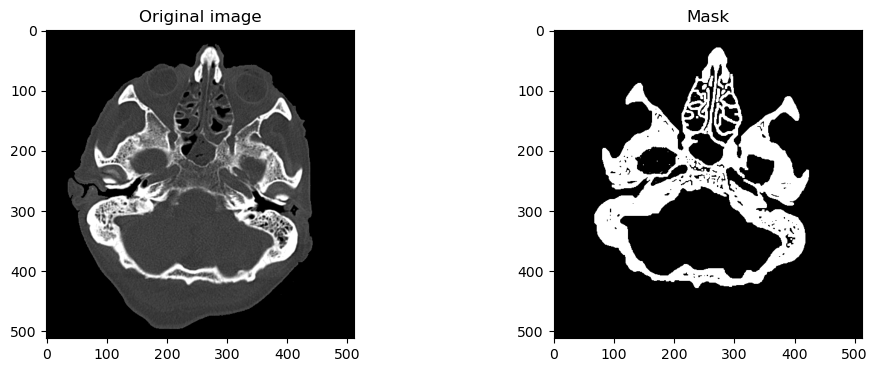

In [30]:
# Check the images 2D
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original9_3D[41,:,:,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask9_3D[41,:,:,0], cmap='gray')
axes[1].set_title('Mask')
    
plt.show()